# Week 8 - Training a Language Model with Attention 

This week, we add an attention mechanism to our model. 

## 1. Setting up data and model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tiktoken
from importlib.metadata import version
import math
import matplotlib.pyplot as plt

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1
tiktoken version: 0.8.0


### 1.1 Data preparation
The steps are the same as last week. 

In [13]:
# Load the text data
with open("jane_austen_emma.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, context_length):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of context_length
        for i in range(0, len(token_ids) - context_length):
            input_sequence = token_ids[i:i + context_length]
            
            #shift to the right
            target_sequence = token_ids[i + 1: i + context_length + 1]

            # input and output are represented as tensors
            self.input_ids.append(torch.tensor(input_sequence))
            self.target_ids.append(torch.tensor(target_sequence))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt, batch_size=8, context_length=4, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, context_length)
    train, dev, test = torch.utils.data.random_split(dataset, [0.8,0.1,0.1])
    
    # Create dataloader
    train_dataloader = DataLoader(
        train,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    dev_dataloader = DataLoader(
        dev,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    test_dataloader = DataLoader(
        test,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return train_dataloader, dev_dataloader, test_dataloader

### 1.2 Initializing a model

We set up our model. We add a second layer and a non-linear activation function.  

In [14]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, hidden_dim=256, dropout=0.2):
        super(LanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(max_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Adding feedforward layers and non-linear activation functions
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)
        
        embeddings = token_embeds + position_embeds
        dropout_layer = self.dropout(embeddings)
        
        # Apply the feedforward layers
        first_layer = self.fc1(dropout_layer)
        non_linearity = self.relu(first_layer)
        # Second layer
        logits = self.fc2(non_linearity)
        return logits

## 2. Implementing Self-Attention

We'll implement self-attention step by step, starting with the basic computations.

### 3.1 Computing Attention Scores

For each token in the sequence, we compute Query, Key, and Value vectors using learnable weight matrices.

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim):
        super(SelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, embedding_dim)
        Q = self.W_q(x)  # Queries
        K = self.W_k(x)  # Keys
        V = self.W_v(x)  # Values
        
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / math.sqrt(self.embedding_dim)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Compute the context vector
        context = torch.matmul(attention_weights, V)
        return context, attention_weights

### 3.2 Masking for Causal Attention

In language models, we often use causal (or masked) attention to prevent the model from attending to future tokens.

In [16]:
class CausalSelfAttention(nn.Module):
    def __init__(self, embedding_dim, max_length):
        super(CausalSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        
        # Register a buffer for the causal mask
        self.register_buffer(  'mask',torch.tril(torch.ones(max_length, max_length)).unsqueeze(0))
        
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.embedding_dim)
        
        # Apply the causal mask
        mask = self.mask[:, :seq_length, :seq_length]
        scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        return context, attention_weights

## 3. Extending to multi-head attention

Multi-head attention allows the model to attend to information from different representation subspaces at different positions.

In [18]:
class MultiHeadCausalAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, max_length, dropout=0.1):
        super(MultiHeadCausalAttention, self).__init__()
        assert embedding_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.embedding_dim = embedding_dim
        
        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer( 'mask',torch.tril(torch.ones(max_length, max_length)).unsqueeze(0))
        
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Split the embedding into self.num_heads different pieces
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim)
        
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply the causal mask
        mask = self.mask[:, :seq_length, :seq_length]
        scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_length, self.embedding_dim)
        
        out = self.fc_out(context)
        return out, attention_weights

## 4. Adding attention to the model

Now, we'll update our model to include the multi-head causal attention layer.

In [19]:
class LanguageModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, hidden_dim=256, num_heads=8, dropout=0.2):
        super(LanguageModelWithAttention, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(max_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.attention = MultiHeadCausalAttention(embedding_dim, num_heads, max_length, dropout)
        
        # Adding more layers and non-linear activation functions
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)
        
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)
        
        # Apply the attention layer
        context, attention_weights = self.attention(embeddings)
        
        # Apply the feedforward layers
        out = self.fc1(context)
        out = self.relu(out)
        logits = self.fc2(out)
        return logits, attention_weights

## 5. Training and evaluation

We'll train the modified model and evaluate its performance.

### 5.1 Setting up training parameters

In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32
context_length = 32  # Increased context size
vocab_size = tokenizer.n_vocab
embedding_dim = 128
hidden_dim = 256
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text, batch_size=batch_size, 
    context_length=context_length,     shuffle=True
)

# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, max_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 5

Using device: cpu


### 5.2 Training the model

In [24]:
train_losses_attention = []
perplexities_attention = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x)
        
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step "
                  f"[{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    train_losses_attention.append(avg_loss)
    perplexities_attention.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/5], Step [0/5746], Loss: 10.8256
Epoch [1/5], Step [10/5746], Loss: 9.4703
Epoch [1/5], Step [20/5746], Loss: 7.3493
Epoch [1/5], Step [30/5746], Loss: 6.7348
Epoch [1/5], Step [40/5746], Loss: 6.6691
Epoch [1/5], Step [50/5746], Loss: 6.5743
Epoch [1/5], Step [60/5746], Loss: 6.3742
Epoch [1/5], Step [70/5746], Loss: 6.4502
Epoch [1/5], Step [80/5746], Loss: 6.3553
Epoch [1/5], Step [90/5746], Loss: 6.4019
Epoch [1/5], Step [100/5746], Loss: 6.3764
Epoch [1/5], Step [110/5746], Loss: 6.2002
Epoch [1/5], Step [120/5746], Loss: 6.2741
Epoch [1/5], Step [130/5746], Loss: 6.0208
Epoch [1/5], Step [140/5746], Loss: 6.1357
Epoch [1/5], Step [150/5746], Loss: 6.1721
Epoch [1/5], Step [160/5746], Loss: 6.0181
Epoch [1/5], Step [170/5746], Loss: 6.1316
Epoch [1/5], Step [180/5746], Loss: 6.0971
Epoch [1/5], Step [190/5746], Loss: 5.9647
Epoch [1/5], Step [200/5746], Loss: 6.0845
Epoch [1/5], Step [210/5746], Loss: 6.0408
Epoch [1/5], Step [220/5746], Loss: 5.9025
Epoch [1/5], Step [23

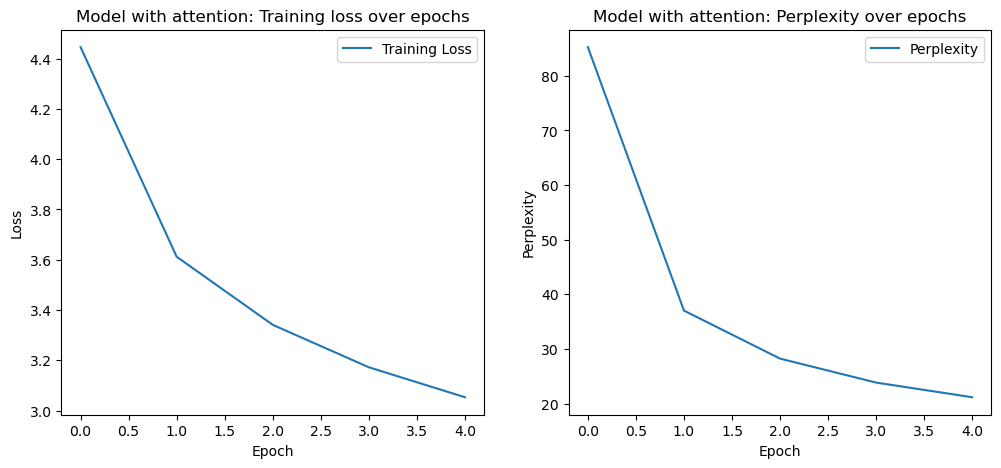

In [25]:
# Plotting loss and perplexity for the attention model

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_attention, label='Training Loss')
plt.title('Model with attention: Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(perplexities_attention, label='Perplexity')
plt.title('Model with attention: Perplexity over epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

### 5.3 Evaluating the model

In [26]:
model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_attention = math.exp(avg_loss)
print(f"Perplexity for the model with attention: {perplexity_attention:.2f}")

Perplexity for the model with attention: 13.65


### 5.4 Generating text

Generate text and analyse how different temperature settings affect the generated text. 

In [27]:
def generate_text(model, tokenizer, start_text, max_length=50, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long,
                          device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(max_length):
            if context.size(1) >= max_length:
                break
            logits, _ = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat(
                [context, next_token_id.unsqueeze(0)], dim=1
            )
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = "Jim was"
generated_text = generate_text(model, tokenizer, start_text, max_length=32)
print("Generated Text:\n")
print(generated_text)

IndexError: index out of range in self